In [1]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join('../../..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


import ND_north_star.src.noise_generators.perlin_noise_generator as PNG
import ND_north_star.src.edge_detection.gradient_detection as ED_sim

from ND_north_star.src.data_fillers.kNN_filler import kNN_data_filler
from ND_north_star.src.utils.sampling_function import random_sampler

## Generate dataset

In [3]:
resolution = 40
octaves = 2
dataset_size = 1000

In [7]:
# dataset = [PNG.normalized_perlin_data([resolution, resolution], octaves=octaves) for _ in range(dataset_size)]

def generate_data(dataset_size, resolution, octaves, percent_sampled=0.5, plot_check=False):
    full_dataset = []
    knn_dataset = []

    # percent_sampled = 0.5
    num_samples = int(resolution * resolution * percent_sampled)

    for i in range(dataset_size):
        
        if i % 5 == 0:
            print(f"Generating data {i}/{dataset_size}")

        perlin_data = PNG.normalized_perlin_data([resolution, resolution], octaves=octaves)
        full_dataset.append(perlin_data)

        perlin_data_dropped = random_sampler(perlin_data, num_samples=num_samples)
        
        k = 3
        knn_data = kNN_data_filler(perlin_data_dropped, k=k)
        knn_dataset.append(knn_data)

        if i == 0 and plot_check:
            PNG.plot_perlin_2D_3D(perlin_data)
            PNG.plot_perlin_2D_3D(perlin_data_dropped)
            PNG.plot_perlin_2D_3D(knn_data)
        
    return full_dataset, knn_dataset

In [6]:
full_dataset, knn_dataset = generate_data(dataset_size, resolution, octaves, percent_sampled=0.5)

Generating data 0/1000
Generating data 5/1000
Generating data 10/1000
Generating data 15/1000
Generating data 20/1000
Generating data 25/1000
Generating data 30/1000
Generating data 35/1000
Generating data 40/1000
Generating data 45/1000
Generating data 50/1000
Generating data 55/1000
Generating data 60/1000
Generating data 65/1000
Generating data 70/1000
Generating data 75/1000
Generating data 80/1000
Generating data 85/1000
Generating data 90/1000
Generating data 95/1000
Generating data 100/1000
Generating data 105/1000
Generating data 110/1000
Generating data 115/1000
Generating data 120/1000
Generating data 125/1000
Generating data 130/1000
Generating data 135/1000
Generating data 140/1000
Generating data 145/1000
Generating data 150/1000
Generating data 155/1000
Generating data 160/1000
Generating data 165/1000


KeyboardInterrupt: 

In [8]:

def coordinates_values_to_image(dataset, dataset_size, resolution):
    X = np.zeros((dataset_size, resolution, resolution))
    
    for i in range(dataset_size):
        _, values = dataset[i]['features'], dataset[i]['values']
        image = np.zeros((resolution, resolution))
        
        for j, (x, y) in enumerate(np.ndindex((resolution, resolution))):
            if j < len(values):
                image[x,y] = values[j]
            else:
                break
        
        X[i] = image
    
    return X

In [9]:
def create_y_boundaries_images(full_dataset, dataset_size, resolution):
    y_images = coordinates_values_to_image(full_dataset, dataset_size, resolution)
    y = [ED_sim.gradient_edge_detection(y_images[i]) for i in range(dataset_size)]

    return y

def create_X_images(knn_dataset, dataset_size, resolution):
    X = coordinates_values_to_image(knn_dataset, dataset_size, resolution)
    return X

In [ ]:
y = create_y_boundaries_images(full_dataset, dataset_size, resolution)
print(y[0])

NameError: name 'full_dataset' is not defined

In [ ]:
X = create_X_images(knn_dataset, dataset_size, resolution)
print(X[0])

NameError: name 'knn_dataset' is not defined

## Train test split

In [9]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, range(len(X)), random_state=2345)

## CNN

In [11]:

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(resolution,resolution,1,), padding = 'same'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2DTranspose(1, (3,3), activation='sigmoid')
])

c:\Users\joesc\anaconda3\envs\ND_north_star\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# model.compile(optimizer='adam',
#               loss='mse',
#               metrics=['mse'])

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['mse'])

In [14]:
X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_test_tensor = tf.convert_to_tensor(y_test)

In [16]:
epochs=400
history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor),
                      epochs=epochs, 
                      batch_size=512)

Epoch 1/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - loss: 8.9124 - mse: 0.0290 - val_loss: 8.9146 - val_mse: 0.0291
Epoch 2/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step - loss: 8.9353 - mse: 0.0291 - val_loss: 8.9140 - val_mse: 0.0290
Epoch 3/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - loss: 8.9103 - mse: 0.0290 - val_loss: 8.9100 - val_mse: 0.0290
Epoch 4/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step - loss: 8.9238 - mse: 0.0290 - val_loss: 8.9096 - val_mse: 0.0289
Epoch 5/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step - loss: 8.9182 - mse: 0.0289 - val_loss: 8.9089 - val_mse: 0.0289
Epoch 6/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - loss: 8.9217 - mse: 0.0288 - val_loss: 8.9104 - val_mse: 0.0289
Epoch 7/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - loss: 8.9170 - mse: 0.0289 - val_loss: 8.9131 - val_mse: 0.0291
Epoch 8/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step - loss: 8.8984 - mse: 0.0290 - val_loss: 8.9132 - val_mse: 0.0290
Epoch 9/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step - loss: 8.927

In [17]:
# model.save("../../checkpoints/"+str(epochs)+".keras")

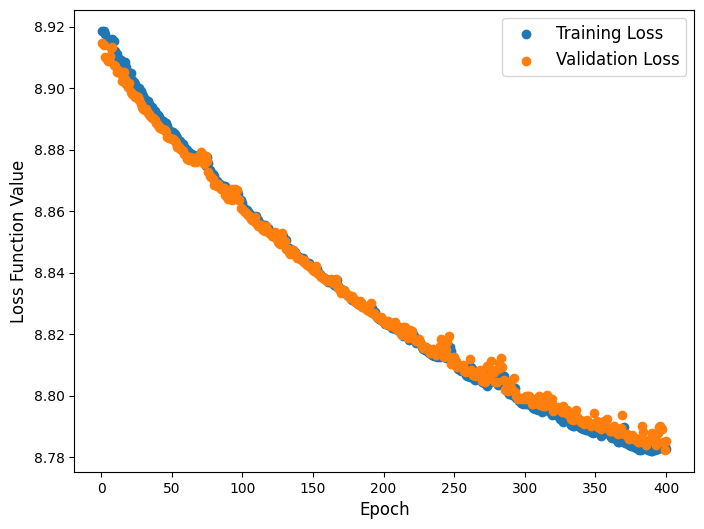

In [18]:
plt.figure(figsize = (8,6))
plt.scatter(range(1, epochs + 1),history.history['loss'], label = "Training Loss")
plt.scatter(range(1, epochs + 1),history.history['val_loss'], label = "Validation Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

In [19]:
pred = model.predict(X_test_tensor)
pred_01 = [e>0.5 for e in pred]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [20]:
n = 20
nn = indices_test[n]

In [25]:
from sklearn.preprocessing import MinMaxScaler

def perlin_M_to_dict(dimension_resolution, octaves, perlin_matrix):
    
    # Convert list to numpy array if needed
    array = np.array(perlin_matrix)
    shape = array.shape

    print(array.shape)
 
    # Generate all possible coordinates in the N-dimensional array
    coordinates = np.indices(shape).reshape(len(shape), -1).T
    data = []      
    # Iterate over the coordinates and get the corresponding values
    for coord in coordinates:
        value = array[tuple(coord)]
        data.append(list(coord) + [value])
    
    # Separate the features and the value column
    features = [d[:-1] for d in data]
    values = [d[-1] for d in data]
    
    # Normalize the feature columns
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(features)
    
    # Create the output dictionary
    perlin_dict = {
        'features': normalized_features.tolist(),
        'values': values,
        'resolution': dimension_resolution,
        'coordinates': [f'x{i}' for i in range(len(shape))],
        'octaves': octaves,
        'dimension': len(dimension_resolution),
    }
    
    return perlin_dict

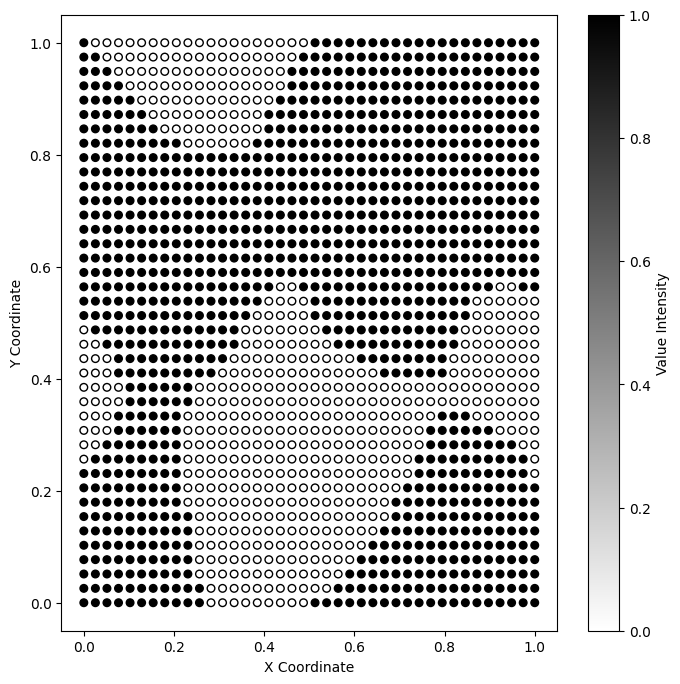

(40, 40)


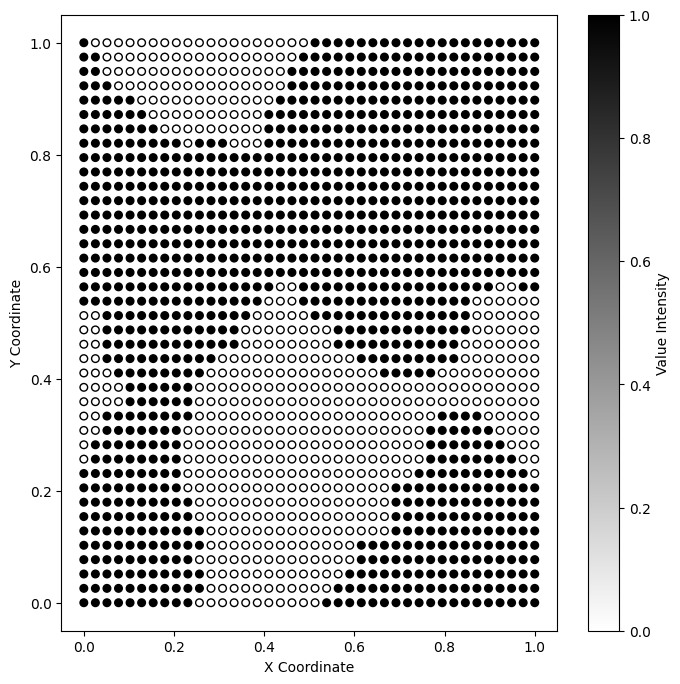

(40, 40)


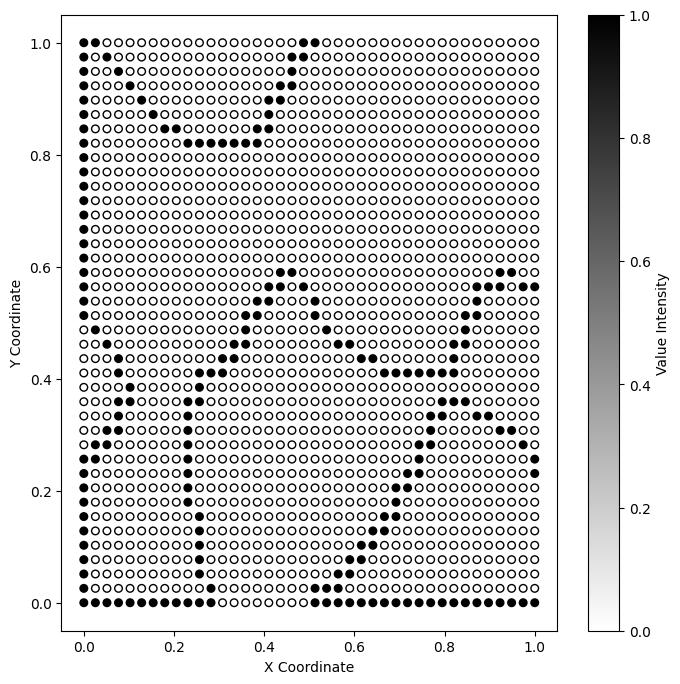

(40, 40, 1)


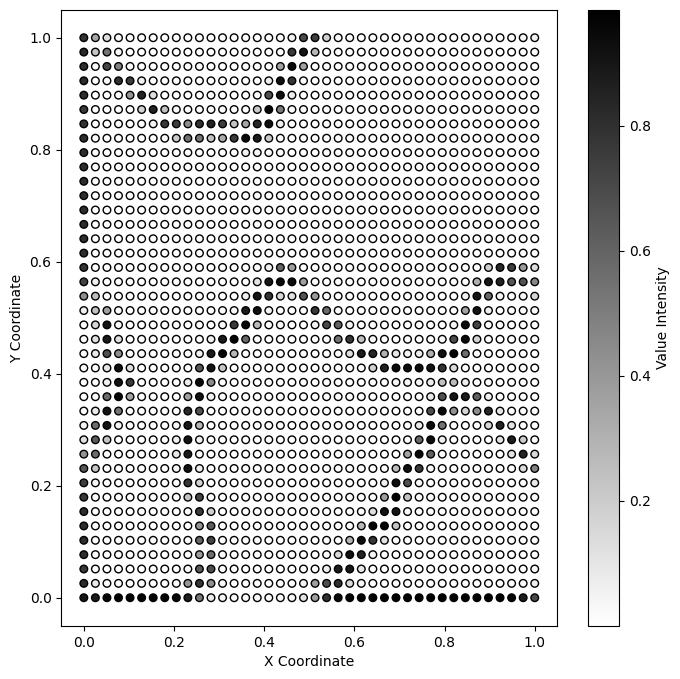

(40, 40, 1)


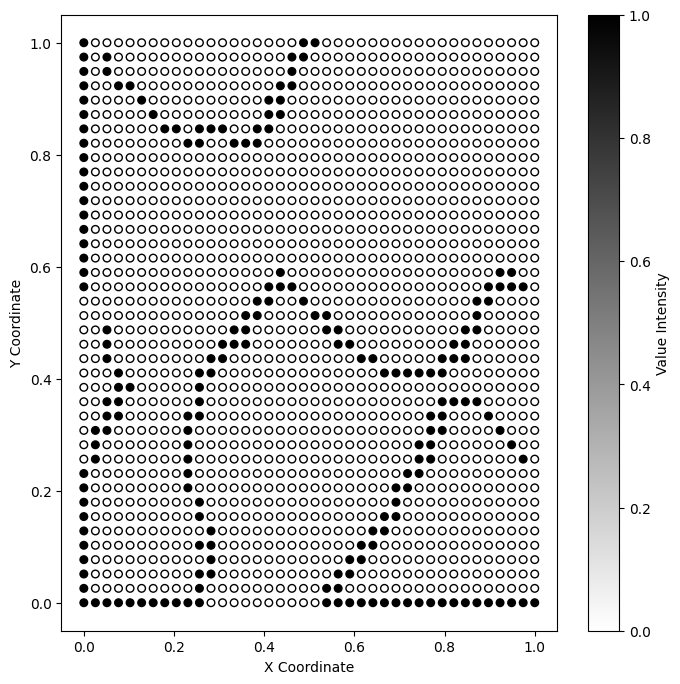

In [29]:
PNG.plot_perlin_2D_3D(full_dataset[nn], 'black')
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], 2, X_test[n]), 'black')
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], 2, y_test[n]), 'black')
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], 2, pred[n]), 'black')
PNG.plot_perlin_2D_3D(perlin_M_to_dict([resolution, resolution], 2, pred_01[n]), 'black')

In [30]:
np.mean([mean_squared_error(np.array(y_test).astype(float)[i], np.array(pred>0.5).reshape(np.array(y_test).shape)[i]) for i in range(len(y_test))])

0.036055

# Test drop percent

In [10]:
resolution = 30
octaves = 4
dataset_size = 1024

drop_perc = [0.2,0.5,0.7,0.9]
epochs = 800

mses = []

for perc in drop_perc:
    print('Sampling percent', perc)
    full_dataset, knn_dataset = generate_data(dataset_size, resolution, octaves, percent_sampled=perc)
    y = create_y_boundaries_images(full_dataset, dataset_size, resolution)
    X = create_X_images(knn_dataset, dataset_size, resolution)
    
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, range(len(X)), random_state=2345)
    
    ######## MODEL ########
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(resolution,resolution,1,), padding = 'same'),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Conv2DTranspose(1, (3,3), activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['mse'])


    X_train_tensor = tf.convert_to_tensor(X_train)
    y_train_tensor = tf.convert_to_tensor(y_train)
    X_test_tensor = tf.convert_to_tensor(X_test)
    y_test_tensor = tf.convert_to_tensor(y_test)

    ######### TRAINING ########
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor),
                        epochs=epochs, 
                        batch_size=32)
    

    ######### PLOTTING ########
    plt.figure(figsize = (8,6))
    plt.scatter(range(1, epochs + 1),history.history['loss'], label = "Training Loss")
    plt.scatter(range(1, epochs + 1),history.history['val_loss'], label = "Validation Loss")

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss Function Value", fontsize=12)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=12)
    plt.show()

    ######### PREDICTION ########
    pred = model.predict(X_test_tensor)
    pred_01 = [e>0.5 for e in pred]

    ########## MSE ##########
    mse = np.mean([mean_squared_error(np.array(y_test).astype(float)[i], np.array(pred>0.5).reshape(np.array(y_test).shape)[i]) for i in range(len(y_test))])
    mses.append(mse)

Sampling percent 0.2
Generating data 0/1000
Generating data 5/1000
Generating data 10/1000
Generating data 15/1000
Generating data 20/1000
Generating data 25/1000
Generating data 30/1000
Generating data 35/1000
Generating data 40/1000
Generating data 45/1000
Generating data 50/1000
Generating data 55/1000
Generating data 60/1000
Generating data 65/1000
Generating data 70/1000
Generating data 75/1000
Generating data 80/1000
Generating data 85/1000
Generating data 90/1000
Generating data 95/1000
Generating data 100/1000
Generating data 105/1000
Generating data 110/1000
Generating data 115/1000
Generating data 120/1000
Generating data 125/1000
Generating data 130/1000
Generating data 135/1000
Generating data 140/1000
Generating data 145/1000
Generating data 150/1000
Generating data 155/1000
Generating data 160/1000
Generating data 165/1000
Generating data 170/1000
Generating data 175/1000
Generating data 180/1000
Generating data 185/1000
Generating data 190/1000
Generating data 195/1000
G

c:\Users\joesc\anaconda3\envs\ND_north_star\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'epochs' is not defined